# Cluster analysis example

### Importing MLlib libraries

In [1]:
%matplotlib inline
import pyspark.mllib.clustering
from pyspark.mllib.clustering import KMeans
import pyspark.mllib.linalg
from pyspark.mllib.linalg import Vectors
from pyspark import SparkConf, SparkContext

### Read data and pre-processing
The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis".
The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres.

In [2]:
conf = SparkConf()
sc = SparkContext(conf=conf)

In [3]:
rawData = sc.textFile("data/iris.csv")

The following code splits the CSV lines into columns and removes the final column. The remaining values
are converted to an array of numeric values (Double objects), and emitted with the final label column in a
tuple.

In [4]:
#rawData.map(_.split(',').last).countByValue().toSeq.sortBy(_._2).reverse.foreach(println)
for x in sorted(rawData.map(lambda x:x.split(',')[-1]).countByValue().items(), key = lambda data:data[1], reverse=True):
    print(x)
'''
val labelsAndData = rawData.map { line =>
    val buffer = line.split(',').toBuffer
    val label = buffer.remove(buffer.length - 1)
    val vector = Vectors.dense(buffer.map(_.toDouble).toArray)
    (label, vector)
}

val data = labelsAndData.values.cache()

'''

def estractLabelVector(line):
    buff = line.split(',')
    label = buff[-1]
    vector = Vectors.dense([float(c) for c in buff[:-1]])
    return (label, vector)

labelsAndData = rawData.map(estractLabelVector)

data = labelsAndData.values().cache()


('Iris-versicolor', 50)
('Iris-virginica', 50)
('Iris-setosa', 50)


In [5]:
'''
val numClusters = 2
val numIterations = 1
val model = KMeans.train(data,numClusters,numIterations)
'''
numClusters = 2
numIterations = 1
model = KMeans.train(data,numClusters,numIterations)

In [6]:
#model.clusterCenters.foreach(println)
for x in model.clusterCenters:
    print(x)

[ 6.2877551   2.88061224  4.94183673  1.68877551]
[ 5.00576923  3.39038462  1.52692308  0.27692308]


In [7]:
'''
val clusterLabelCount = labelsAndData.map { case (label, datum) =>
  val cluster = model.predict(datum)
  (cluster, label)}.countByValue()
  clusterLabelCount.toSeq.sorted.foreach { case ((cluster, label), count) =>
  println(f"$cluster%1s$label%18s$count%8s")
  }
'''

def match(data):
    cluster = model.predict(data[1])
    return (cluster, data[0])

clusterLabelCount = labelsAndData.map(match).countByValue()

for key in clusterLabelCount.keys():
    print("%1s%18s%8s" % (key[0], key[1], clusterLabelCount[key]))


0   Iris-versicolor      47
0    Iris-virginica      50
1   Iris-versicolor       3
1       Iris-setosa      50


### Write sample and total result in a directory hadoop style and coalesce all in one file

In [8]:
'''  
val sample = data.map(datum => model.predict(datum) + "," +datum.toArray.mkString(",")).sample(false,0.05)
val total = data.map(datum => model.predict(datum) + "," +datum.toArray.mkString(","))
sample.saveAsTextFile("share/sample")
sample.coalesce(1).saveAsTextFile("share/sample_coalesce")
'''
total = data.map(lambda datum: str(model.predict(datum)) + "," +",".join([str(c) for c in datum]))
sample = total.sample(False,0.05)
sample.saveAsTextFile("outPython/sample")
sample.coalesce(1).saveAsTextFile("outPython/sample_coalesce")

Py4JJavaError: An error occurred while calling o59.saveAsTextFile.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory file:/home/jovyan/work/notebooks/Giorgio/outPython/sample already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:132)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply$mcV$sp(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1065)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1065)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1065)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply$mcV$sp(PairRDDFunctions.scala:989)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:965)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:965)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:965)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply$mcV$sp(PairRDDFunctions.scala:897)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:897)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:897)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:896)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply$mcV$sp(RDD.scala:1426)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1405)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1405)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:306)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1405)
	at org.apache.spark.api.java.JavaRDDLike$class.saveAsTextFile(JavaRDDLike.scala:522)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsTextFile(JavaRDDLike.scala:47)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)


### Choice of K
A clustering could be considered good if each data point were near to its closest centroid. So, we define a
Euclidean distance function, and a function that returns the distance from a data point to its nearest cluster’s
centroid. From this, it’s possible to define a function that measures the average distance to centroid, for a
model built with a given k. This is an internal quality measure.

In [9]:
#def distance(a: Vector, b: Vector) =math.sqrt(a.toArray.zip(b.toArray).map(p => p._1 - p._2).map(d => d * d).sum)
import numpy as np

def distance(a, b):
    return np.linalg.norm(np.asarray(a)-np.asarray(b))

'''
def distToCentroid(datum: Vector, model: KMeansModel) = {
      val cluster = model.predict(datum)
      val centroid = model.clusterCenters(cluster)
      distance(centroid, datum)
}   
'''
def distToCentroid(datum, model):
    cluster = model.predict(datum)
    centroid = model.clusterCenters[cluster]
    return distance(centroid, datum)

'''
def clusteringScore(data: RDD[Vector], k: Int): Double = {
      val kmeans = new KMeans()
      kmeans.setK(k)
      kmeans.setRuns(30)
      kmeans.setEpsilon(1.0e-6)
      val model = kmeans.run(data)
      data.map(datum => distToCentroid(datum, model)).mean()
}
'''
def clusteringScore(data, k):
    model = KMeans.train(data, k, runs=30, epsilon=1.0e-6)
    return data.map(lambda datum: distToCentroid(datum, model)).mean()

Evaluate score values for different k from 1 to 10.

In [10]:
#(1 to 10 by 1).map(k => (k, clusteringScore(data, k))).foreach(println)
y = []
for k in range(10):
    score = clusteringScore(data,k+1)
    y.append(score)
    print((k+1,score))

(1, 1.9440683605553895)
(2, 0.85557776952665299)
(3, 0.64803049049344341)
(4, 0.55738477273333131)
(5, 0.50965219511182869)
(6, 0.4670733963396439)
(7, 0.4388470923820707)
(8, 0.41232974395823663)
(9, 0.3947106465063559)
(10, 0.38427664500134867)


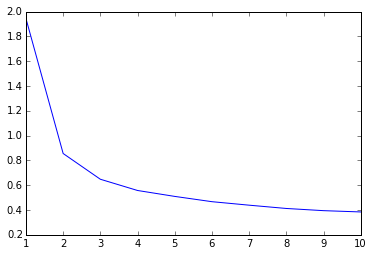

In [11]:
import matplotlib.pyplot as pyplot
pyplot.plot(range(1,11),y)

### Data Normalization
Since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing removes this bias. We can normalize each feature by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation.

In [13]:
'''
def buildNormalizationFunction(data: RDD[Vector]): (Vector => Vector) = {
    val dataAsArray = data.map(_.toArray)
    val numCols = dataAsArray.first().length
    val n = dataAsArray.count()
    val sums = dataAsArray.reduce(
      (a, b) => a.zip(b).map(t => t._1 + t._2))
    val sumSquares = dataAsArray.fold(
        new Array[Double](numCols)
      )(
        (a, b) => a.zip(b).map(t => t._1 + t._2 * t._2)
      )
    val stdevs = sumSquares.zip(sums).map {
      case (sumSq, sum) => math.sqrt(n * sumSq - sum * sum) / n
    }
    val means = sums.map(_ / n)

    (datum: Vector) => {
      val normalizedArray = (datum.toArray, means, stdevs).zipped.map(
        (value, mean, stdev) =>
          if (stdev <= 0)  (value - mean) else  (value - mean) / stdev
      )
      Vectors.dense(normalizedArray)
    }
}
'''

def buildNormalizationFunction(data):
    dataAsArray = data.map(lambda datum: np.asarray(datum))
    numCols = dataAsArray.first().size
    n = dataAsArray.count()
    sums = dataAsArray.reduce(lambda a,b: [t1 + t2 for t1, t2 in zip(a,b)])
    sumSquares = dataAsArray.reduce(lambda a,b: [t1 + t2*t2 for t1, t2 in zip(a,b)])
    stdevs = [(n * sumSq - sum**2)**(1/2)/n for sumSq, sum in zip(sumSquares, sums)]
    means = [s/n for s in sums]
    return dataAsArray.map(lambda datum :
                           Vectors.dense([value - mean if stdev == 0 else (value - mean) / stdev
                                          for value, mean, stdev in zip(datum, means, stdevs)])
                          )

In [14]:
normalizedData = buildNormalizationFunction(data).cache()

In [15]:
'''
(1 to 10 by 1).map(k =>
      (k, clusteringScore(normalizedData, k))).foreach(println)
'''
y = []
for k in range(10):
    score = clusteringScore(normalizedData,k+1)
    y.append(score)
    print((k+1,score))

(1, 0.036432654871608426)
(2, 0.01634733527199109)
(3, 0.010421227668008742)
(4, 0.0087876646616176085)
(5, 0.0078241687917766645)
(6, 0.0071265334725371509)
(7, 0.0065721942788648253)
(8, 0.0061513374927674707)
(9, 0.0057848592513019929)
(10, 0.0056017507571259903)


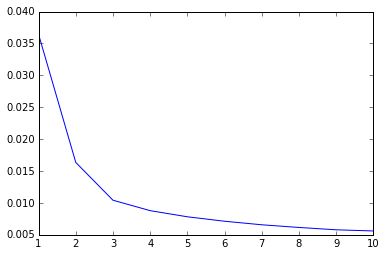

In [16]:
pyplot.plot(range(1,11),y)

### Definition of Entropy measure
The are different metrics for homogeneity. Entropy is used here for illustration. A good clustering would have clusters whose collections of labels are homogeneous and so have low entropy. A weighted average of entropy can therefore be used as a cluster score. This is an external quality measure.

In [19]:
'''
def entropy(counts: Iterable[Int]) = {
    val values = counts.filter(_ > 0)
    val n: Double = values.sum
    values.map { v =>
    val p = v / n 
    -p * math.log(p)
    }.sum
}
'''
import math
def entropy(counts):
    values = [float(x) for x in filter(lambda x: x>0, counts)]
    n = float(sum(values))
    return sum(map(lambda v: - v/n * math.log(v/n), values))

In [20]:
'''
def buildCategoricalAndLabelFunction(rawData: RDD[String]): (String => (String,Vector)) = {
val splitData = rawData.map(_.split(','))
   (line: String) => {
      val buffer = line.split(',').toBuffer 
      val label = buffer.remove(buffer.length - 1)
      val vector = buffer.map(_.toDouble)
      (label, Vectors.dense(vector.toArray))
    }
}
'''
def buildCategoricalAndLabelFunction(rawData):
    return rawData.map(estractLabelVector)

### Entropy for choosing K

In [21]:
'''
def clusteringScore3(normalizedLabelsAndData: RDD[(String,Vector)], k: Int) = {
    val kmeans = new KMeans()
    kmeans.setK(k)
    kmeans.setRuns(10)
    kmeans.setEpsilon(1.0e-6)
    val model = kmeans.run(normalizedLabelsAndData.values)
    val labelsAndClusters = normalizedLabelsAndData.mapValues(model.predict)
    val clustersAndLabels = labelsAndClusters.map(_.swap)
    val labelsInCluster = clustersAndLabels.groupByKey().values
    val labelCounts = labelsInCluster.map(_.groupBy(l => l).map(_._2.size))
    val n = normalizedLabelsAndData.count()
    labelCounts.map(m => m.sum * entropy(m)).sum / n
}

val parseFunction = buildCategoricalAndLabelFunction(rawData)
val labelsAndData = rawData.map(parseFunction)
val normalizedLabelsAndData =
      labelsAndData.mapValues(buildNormalizationFunction(labelsAndData.values)).cache()
(1 to 10 by 1).map(k =>
      (k, clusteringScore3(normalizedLabelsAndData, k))).foreach(println)
normalizedLabelsAndData.unpersist()
'''
from itertools import groupby
def clusteringScore3(normalizedLabelsAndData, k):
    model = KMeans.train(normalizedLabelsAndData.values(), k, runs=30, epsilon=1.0e-6)
    labelsAndClusters = normalizedLabelsAndData.mapValues(model.predict)
    clustersAndLabels = labelsAndClusters.map(lambda x: (x[1],x[0]))
    labelsInCluster = clustersAndLabels.groupByKey().values()
    labelCounts = labelsInCluster.map(lambda x: [len(list(group)) for key, group in groupby(x, lambda l:l)])
    n = float(normalizedLabelsAndData.count())
    return labelCounts.map(lambda m: sum(m) * entropy(m)).sum() / n
    
def buildNormalizationFunctionWithLabels(data):
    dataAsArray = data.values().map(lambda datum: np.asarray(datum))
    numCols = dataAsArray.first().size
    n = dataAsArray.count()
    sums = dataAsArray.reduce(lambda a,b: [t1 + t2 for t1, t2 in zip(a,b)])
    sumSquares = dataAsArray.reduce(lambda a,b: [t1 + t2*t2 for t1, t2 in zip(a,b)])
    stdevs = [(n * sumSq - sum**2)**(1/2)/n for sumSq, sum in zip(sumSquares, sums)]
    means = [s/n for s in sums]
    return data.map(lambda datum :
                           (datum[0], Vectors.dense([value - mean if stdev == 0 else (value - mean) / stdev
                                                     for value, mean, stdev in zip(datum[1], means, stdevs)]))
                          )
    
labelsAndData = buildCategoricalAndLabelFunction(rawData)
normalizedLabelsAndData = buildNormalizationFunctionWithLabels(labelsAndData)
y = []
for k in range(10):
    score = clusteringScore3(normalizedLabelsAndData,k+1)
    y.append(score)
    print((k+1,score))
normalizedLabelsAndData.unpersist()

(1, 1.0986122886681096)
(2, 0.4620981203732969)
(3, 0.16554309474734444)
(4, 0.16240112916183208)
(5, 0.12799481690635414)
(6, 0.12881643307972163)
(7, 0.13391811468573372)
(8, 0.1320532655761455)
(9, 0.1320532655761455)
(10, 0.1121122708717687)


PythonRDD[1514] at RDD at PythonRDD.scala:43

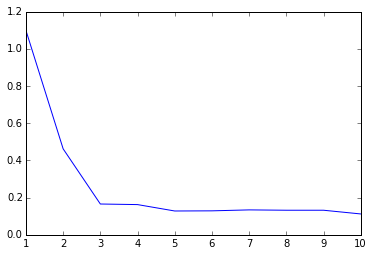

In [22]:
pyplot.plot(range(1,11),y)